# 이미지 분석을 통한 데뷔조 컨셉 추천

## seed 고정

In [1]:
# seed 고정

import keras
import random
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model

# 데이터 불러오기
random.seed(1)
np.random.seed(1)
os.environ["PYTHONHASHSEED"] = str(1)
os.environ['TF_DETERMINISTIC_OPS'] = str(1)
tf.random.set_seed(1)

## 이미지 가져오기

구글 이미지 크롤링을 통해 각 그룹의 멤버별 이미지 50장씩을 저장하여 데이터로 사용한다. (약 1500개 이미지)

컨셉별로 대표적인 7개 그룹을 선정하였다.

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
from skimage import io
img_dc = io.imread_collection('/content/drive/MyDrive/P4_concept/dreamcatcher/*.jpg')  # 0
img_mmm = io.imread_collection('/content/drive/MyDrive/P4_concept/mamamoo/*.jpg')      # 1
img_bp = io.imread_collection('/content/drive/MyDrive/P4_concept/blackpink/*.jpg')    # 2
img_izone = io.imread_collection('/content/drive/MyDrive/P4_concept/izone/*.jpg')     # 3
img_omg = io.imread_collection('/content/drive/MyDrive/P4_concept/omg/*.jpg')        # 4
img_itzy = io.imread_collection('/content/drive/MyDrive/P4_concept/itzy/*.jpg')      # 5
img_twice = io.imread_collection('/content/drive/MyDrive/P4_concept/twice/*.jpg')     # 6

## 이미지를 numpy 배열로 읽어오고, 정규화, resize, 라벨값 주기

In [83]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.transform import resize
from keras.utils import np_utils

def labeling(images, label):
  for i, image in enumerate(images):
    image0 = resize(image,(256,256,3))   # resize (256,256)
    arr_img = img_to_array(image0)
    img = arr_img.reshape((1,)+arr_img.shape)
    if i == 0:
      container = img
      labels = label
    else:
      container = np.vstack([container, img])
      labels = np.vstack([labels, label])

  X = container
  y = labels

  return X, y


In [85]:
X_dc, y_dc = labeling(img_dc, 0)
X_mmm, y_mmm = labeling(img_mmm, 1)
X_bp, y_bp = labeling(img_bp, 2)
X_izone, y_izone = labeling(img_izone, 3)
X_omg, y_omg = labeling(img_omg, 4)
X_itzy, y_itzy = labeling(img_itzy, 5)
X_twice, y_twice = labeling(img_twice, 6)

In [86]:
X = np.vstack([X_dc, X_mmm, X_bp, X_izone, X_omg, X_itzy, X_twice])
y = np.vstack([y_dc, y_mmm, y_bp, y_izone, y_omg, y_itzy, y_twice])

In [87]:
X[0]

array([[[0.15196079, 0.4127451 , 0.31605393],
        [0.17254902, 0.422549  , 0.30441177],
        [0.18737745, 0.45343137, 0.3254902 ],
        ...,
        [0.49129903, 0.7245098 , 0.70980394],
        [0.47144607, 0.71727943, 0.70686275],
        [0.50894606, 0.74129903, 0.7377451 ]],

       [[0.13088235, 0.3897059 , 0.3019608 ],
        [0.18492647, 0.42169118, 0.3064951 ],
        [0.21507353, 0.4617647 , 0.3254902 ],
        ...,
        [0.4387255 , 0.6839461 , 0.67806375],
        [0.42205882, 0.6745098 , 0.68492645],
        [0.42107844, 0.68578434, 0.6824755 ]],

       [[0.09473039, 0.35931373, 0.2784314 ],
        [0.14252451, 0.39313725, 0.2877451 ],
        [0.18982843, 0.44558823, 0.31164217],
        ...,
        [0.5647059 , 0.7647059 , 0.7735294 ],
        [0.56421566, 0.76213235, 0.7802696 ],
        [0.55784315, 0.76115197, 0.7790441 ]],

       ...,

       [[0.18296568, 0.21470588, 0.23860294],
        [0.17769608, 0.21887255, 0.23811275],
        [0.17941177, 0

In [88]:
from numpy import save
save('X.npy', X)
save('y.npy', y)

In [89]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

In [90]:
[X_train.shape, y_train.shape],[X_test.shape, y_test.shape]

([(1887, 256, 256, 3), (1887, 1)], [(472, 256, 256, 3), (472, 1)])

## 모델(ResNet50 기반)

In [219]:
resnet = ResNet50(weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False

In [220]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(resnet.input, predictions)

In [221]:
model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

- 이미지 증폭

In [222]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [223]:
datagen.fit(X_train)

NameError: ignored

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 학습시킨 데이터 저장
checkpoint_filepath = "FMbest.hdf5"

# early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Val Set 기준 최적모델 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [ ]:
results = model.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32, 
           epochs=30,
           validation_data=(X_test, y_test),
           callbacks=[early_stop, save_best])

## - 성능이 좋지 않아서, 얼굴인식에 좀 더 최적화된 모델과 방법을 적용하기로 했다.

## 모델(VGGFace 기반) + Face Detection

In [2]:
!pip install deepface

     |████████████████████████████████| 61kB 5.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 2.3MB 15.3MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9693 sha256=04a8a6abf18a8873c9607f651b4909d3b7fa0fb29986e3b9345ac3b3e4eabe8e
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


구글 이미지 크롤링을 통해 각 그룹의 멤버별 이미지 50장씩을 저장하여 데이터로 사용한다. (약 1500개 이미지)

컨셉별로 대표적인 7개 그룹을 선정하였다.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from skimage import io
img_dc = io.imread_collection('/content/drive/MyDrive/P4_concept/dreamcatcher/*.jpg')  # 0
img_mmm = io.imread_collection('/content/drive/MyDrive/P4_concept/mamamoo/*.jpg')      # 1
img_bp = io.imread_collection('/content/drive/MyDrive/P4_concept/blackpink/*.jpg')    # 2
img_izone = io.imread_collection('/content/drive/MyDrive/P4_concept/izone/*.jpg')     # 3
img_omg = io.imread_collection('/content/drive/MyDrive/P4_concept/omg/*.jpg')        # 4
img_itzy = io.imread_collection('/content/drive/MyDrive/P4_concept/itzy/*.jpg')      # 5
img_twice = io.imread_collection('/content/drive/MyDrive/P4_concept/twice/*.jpg')     # 6

### 이미지를 numpy 배열로 읽어오고, 정규화, resize, 라벨값 주기

In [5]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.transform import resize
from keras.utils import np_utils
from deepface.commons import functions

def labeling_vgg(images, label):
  for i, image in enumerate(images):
    try:
      image0 = functions.detect_face(image)   # face detection
      image1 = resize(image0[0],(224,224,3))   # resize (224,224,3)
      arr_img = img_to_array(image1)
      img = arr_img.reshape((1,)+arr_img.shape)
      if i == 0:
        container = img
        labels = label
      else:
        container = np.vstack([container, img])
        labels = np.vstack([labels, label])
    except:
      continue  # 얼굴 감지 못하면 그냥 뛰어넘기
  X = container
  y = labels

  return X, y


- 이미지 하나 뽑아서 확인해보기

In [6]:
image0 = functions.detect_face(img_bp[11])

In [7]:
image0[0].shape

(78, 78, 3)

In [8]:
image1 = resize(image0[0],(224,224,3))
image1.shape

(224, 224, 3)

In [9]:
image1

array([[[0.99488796, 0.97228641, 0.86563008],
        [0.99488796, 0.97228641, 0.86643259],
        [0.99488796, 0.97228641, 0.86551206],
        ...,
        [0.87042981, 0.69996327, 0.54978906],
        [0.87906811, 0.71041213, 0.5597929 ],
        [0.87153729, 0.70130286, 0.5510716 ]],

       [[0.99964986, 0.96157213, 0.85809926],
        [0.99964986, 0.96157213, 0.85926316],
        [0.99964986, 0.96157213, 0.85792809],
        ...,
        [0.86610902, 0.69965502, 0.53594446],
        [0.87433278, 0.7092748 , 0.54553376],
        [0.86716335, 0.70088832, 0.53717385]],

       [[0.99418768, 0.97386204, 0.86673755],
        [0.99418768, 0.97386204, 0.86748692],
        [0.99418768, 0.97386204, 0.86662735],
        ...,
        [0.87106522, 0.7000086 , 0.55182503],
        [0.87976448, 0.71057939, 0.56188983],
        [0.87218051, 0.70136383, 0.55311539]],

       ...,

       [[0.64906666, 0.54087166, 0.44594955],
        [0.6559863 , 0.54629258, 0.45211983],
        [0.64804906, 0

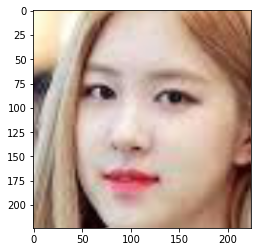

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure()

plt.imshow(image1[:,:,::1])

- 샘플 이미지에서 얼굴 부분만 잘 감지되어 resize, normalize 된 것을 볼 수 있다.

In [11]:
X_dc, y_dc = labeling_vgg(img_dc, 0)
X_mmm, y_mmm = labeling_vgg(img_mmm, 1)
X_bp, y_bp = labeling_vgg(img_bp, 2)
X_izone, y_izone = labeling_vgg(img_izone, 3)
X_omg, y_omg = labeling_vgg(img_omg, 4)
X_itzy, y_itzy = labeling_vgg(img_itzy, 5)
X_twice, y_twice = labeling_vgg(img_twice, 6)

In [12]:
X_vgg = np.vstack([X_dc, X_mmm, X_bp, X_izone, X_omg, X_itzy, X_twice])
y_vgg = np.vstack([y_dc, y_mmm, y_bp, y_izone, y_omg, y_itzy, y_twice])

In [13]:
X_vgg[0]

array([[[0.17695078, 0.19287714, 0.20696278],
        [0.18007202, 0.1922369 , 0.20712285],
        [0.17070828, 0.19415766, 0.20664266],
        ...,
        [0.5609444 , 0.6264906 , 0.6106443 ],
        [0.5532613 , 0.6255302 , 0.60560226],
        [0.5558223 , 0.6258503 , 0.60728294]],

       [[0.17054822, 0.18439376, 0.19815926],
        [0.17126851, 0.1812725 , 0.1959984 ],
        [0.16910765, 0.19063625, 0.20248099],
        ...,
        [0.56366545, 0.62921166, 0.6128852 ],
        [0.5547819 , 0.6270508 , 0.6061625 ],
        [0.5577431 , 0.6277711 , 0.6084034 ]],

       [[0.1897559 , 0.20984393, 0.22456983],
        [0.19767907, 0.21416567, 0.22937174],
        [0.17390956, 0.20120049, 0.21496598],
        ...,
        [0.5555022 , 0.6210484 , 0.6061625 ],
        [0.5502201 , 0.622489  , 0.6044818 ],
        [0.5519808 , 0.6220088 , 0.60504204]],

       ...,

       [[0.36206484, 0.31428573, 0.29059625],
        [0.41856742, 0.37254903, 0.34557822],
        [0.24905962, 0

In [126]:
# from numpy import save
# save('X_vgg.npy', X_vgg)
# save('y_vgg.npy', y_vgg)

In [6]:
X_vgg = np.load('/content/drive/MyDrive/P4_concept/X_vgg.npy')
y_vgg = np.load('/content/drive/MyDrive/P4_concept/y_vgg.npy')

In [7]:
from sklearn.model_selection import train_test_split
X_train_vgg, X_test_vgg, y_train_vgg, y_test_vgg = train_test_split(X_vgg, y_vgg, test_size=0.2, stratify=y_vgg, random_state=11)

In [8]:
[X_train_vgg.shape, y_train_vgg.shape],[X_test_vgg.shape, y_test_vgg.shape]

([(1115, 224, 224, 3), (1115, 1)], [(279, 224, 224, 3), (279, 1)])

### Deepface VGGFace

In [87]:
from deepface.basemodels import VGGFace, OpenFace, Facenet, FbDeepFace
from keras.models import model_from_json
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Activation

# model_vgg=VGGFace.loadModel()  # 너무 많이 로드해서 안된다고 나옴(?) -> 알아서 다운받으라

# VGGFace model
vgg = VGGFace.baseModel()

for layer in vgg.layers:
    layer.trainable = False
vgg.load_weights('/content/drive/MyDrive/P4_concept/vgg_face_weights.h5')

In [88]:
model_vgg = Model(inputs=vgg.layers[0].input
, outputs=vgg.layers[-2].output)

In [89]:
x = model_vgg.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
model_vgg_face = Model(model_vgg.input, predictions)

In [90]:
model_vgg_face.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_78_input (Inp [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d_78 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_79 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_80 (ZeroPaddi (None, 114, 114, 64)      0  

- 이미지 증폭

In [70]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [71]:
datagen.fit(X_train_vgg)

In [72]:
y_train_vgg

array([[0],
       [1],
       [4],
       ...,
       [4],
       [1],
       [6]])

In [91]:
model_vgg_face.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
# 학습시킨 데이터 저장
checkpoint_filepath = "FMbest_vgg_face_11.hdf5"

# early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Val Set 기준 최적모델 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [92]:
results = model_vgg_face.fit(datagen.flow(X_train_vgg, y_train_vgg),
           epochs=100,
           validation_data=(X_test_vgg, y_test_vgg),
           callbacks=[early_stop, save_best])

Epoch 1/100
35/35 [==============================] - 15s 404ms/step - loss: 1.9325 - accuracy: 0.3368 - val_loss: 1.9098 - val_accuracy: 0.9892

Epoch 00001: val_loss improved from inf to 1.90983, saving model to FMbest_vgg_face_11.hdf5
Epoch 2/100
35/35 [==============================] - 14s 392ms/step - loss: 1.8796 - accuracy: 0.6781 - val_loss: 1.8911 - val_accuracy: 0.8495

Epoch 00002: val_loss improved from 1.90983 to 1.89115, saving model to FMbest_vgg_face_11.hdf5
Epoch 3/100
35/35 [==============================] - 14s 404ms/step - loss: 1.8233 - accuracy: 0.5564 - val_loss: 1.8676 - val_accuracy: 0.4014

Epoch 00003: val_loss improved from 1.89115 to 1.86755, saving model to FMbest_vgg_face_11.hdf5
Epoch 4/100
35/35 [==============================] - 14s 388ms/step - loss: 1.7727 - accuracy: 0.4483 - val_loss: 1.8443 - val_accuracy: 0.4480

Epoch 00004: val_loss improved from 1.86755 to 1.84432, saving model to FMbest_vgg_face_11.hdf5
Epoch 5/100
35/35 [=====================

- loss가 점차 줄어드는 것으로 보아 학습이 진행되고 있는 것 같다. (val_accuracy는 오히려 감소 추세)

In [150]:
model_vgg_face.save('/content/drive/MyDrive/P4_concept/model')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/P4_concept/model/assets


## 비교 - ResNet50 + Face Detection

In [94]:
resnet = ResNet50(weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False

In [95]:
x = resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)
model = Model(resnet.input, predictions)

In [96]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

- 이미지 증폭

In [97]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

In [98]:
datagen.fit(X_train_vgg)

In [108]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.1, beta_1 = 0.89),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [104]:
# 학습시킨 데이터 저장
checkpoint_filepath = "FMbest_detect_resnet.hdf5"

# early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Val Set 기준 최적모델 찾기
save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [109]:
results_detect_resnet = model.fit(datagen.flow(X_train_vgg, y_train_vgg, batch_size=128),
          steps_per_epoch=len(X_train_vgg) / 128, 
           epochs=100,
           validation_data=(X_test_vgg, y_test_vgg),
           callbacks=[early_stop, save_best])

Epoch 1/100
8/8 [==============================] - 17s 1s/step - loss: 3.6775 - accuracy: 0.4961 - val_loss: 1.9591 - val_accuracy: 1.0000

Epoch 00001: val_loss did not improve from 1.92719
Epoch 2/100
8/8 [==============================] - 11s 1s/step - loss: 1.9596 - accuracy: 1.0000 - val_loss: 1.9319 - val_accuracy: 1.0000

Epoch 00002: val_loss did not improve from 1.92719
Epoch 3/100
8/8 [==============================] - 12s 1s/step - loss: 1.9325 - accuracy: 1.0000 - val_loss: 1.9258 - val_accuracy: 1.0000

Epoch 00003: val_loss improved from 1.92719 to 1.92580, saving model to FMbest_detect_resnet.hdf5
Epoch 4/100
8/8 [==============================] - 12s 1s/step - loss: 1.9798 - accuracy: 0.7324 - val_loss: 1.9305 - val_accuracy: 1.0000

Epoch 00004: val_loss did not improve from 1.92580
Epoch 5/100
8/8 [==============================] - 12s 1s/step - loss: 1.9585 - accuracy: 1.0000 - val_loss: 1.9332 - val_accuracy: 0.0000e+00

Epoch 00005: val_loss did not improve from 1.

- Face Detection을 유지하고 model만 ResNet50으로 다시 변경해보면, val_loss가 줄어들지 않는 것을 볼 수 있다.
- 따라서 **VGGFace** 모델을 채택

## CV 적용

In [110]:
from sklearn.model_selection import KFold

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1

acc_per_fold = []
loss_per_fold =[]

for train, test in kfold.split(X_train_vgg, y_train_vgg):

  # Define the model architecture
  vgg = VGGFace.baseModel()

  for layer in vgg.layers:
    layer.trainable = False
  
  vgg.load_weights('/content/drive/MyDrive/P4_concept/vgg_face_weights.h5')
  model_vgg_cv = Model(inputs=vgg.layers[0].input
  , outputs=vgg.layers[-2].output)

  x = model_vgg_cv.output
  x = Dense(1024, activation='relu')(x)
  predictions = Dense(7, activation='softmax')(x)
  model_vgg_face_cv = Model(model_vgg_cv.input, predictions)

  # Augmentation
  datagen = ImageDataGenerator(featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
  datagen.fit(X_train_vgg)

  # Compile the model
  model_vgg_face_cv.compile(optimizer=tf.keras.optimizers.SGD(lr=0.1),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

  # 학습시킨 데이터 저장
  checkpoint_filepath = "FMbest_vgg_face_cv5.hdf5"

  # early stopping
  early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

  # Val Set 기준 최적모델 찾기
  save_best = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
      save_weights_only=True, mode='auto', save_freq='epoch', options=None)
  
  # Generate a print
  print('------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model_vgg_face_cv.fit(datagen.flow(X_train_vgg, y_train_vgg, batch_size=32),
          steps_per_epoch=len(X_train_vgg) / 32, 
           epochs=30,
           validation_data=(X_test_vgg, y_test_vgg),
           callbacks=[early_stop, save_best])

  # Generate generalization metrics
  scores = model_vgg_face_cv.evaluate(X_test_vgg, y_test_vgg, verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

------------------------------------------------------------
Training for fold 1 ...
Epoch 1/30
34/34 [==============================] - 15s 394ms/step - loss: 1.9303 - accuracy: 0.3004 - val_loss: 1.9076 - val_accuracy: 0.9319

Epoch 00001: val_loss improved from inf to 1.90762, saving model to FMbest_vgg_face_cv5.hdf5
Epoch 2/30
34/34 [==============================] - 14s 394ms/step - loss: 1.8692 - accuracy: 0.6917 - val_loss: 1.8868 - val_accuracy: 0.6380

Epoch 00002: val_loss improved from 1.90762 to 1.88679, saving model to FMbest_vgg_face_cv5.hdf5
Epoch 3/30
34/34 [==============================] - 13s 382ms/step - loss: 1.8199 - accuracy: 0.3335 - val_loss: 1.8655 - val_accuracy: 0.7921

Epoch 00003: val_loss improved from 1.88679 to 1.86546, saving model to FMbest_vgg_face_cv5.hdf5
Epoch 4/30
34/34 [==============================] - 13s 375ms/step - loss: 1.7569 - accuracy: 0.4913 - val_loss: 1.8349 - val_accuracy: 0.5914

Epoch 00004: val_loss improved from 1.86546 to 1.834

- Score for fold 1: loss of 1.345; accuracy of 24.01%
- Score for fold 2: loss of 1.328; accuracy of 32.61%
- Score for fold 3: loss of 1.351; accuracy of 29.03%
- Score for fold 4: loss of 1.323; accuracy of 37.27%
- Score for fold 5: loss of 1.351; accuracy of 47.31%

Cross validation(K-fold:5) 결과, Loss는 1.3, accuracy는 33.8% 정도이다.

In [111]:
model_vgg_face_cv.save('/content/drive/MyDrive/P4_concept')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/P4_concept/assets


# 신규 이미지 분석

In [151]:
from tensorflow import keras

re_model = keras.models.load_model('/content/drive/MyDrive/P4_concept')
re_model_nocv = keras.models.load_model('/content/drive/MyDrive/P4_concept/model')

In [134]:
from skimage import io
images = io.imread_collection('/content/drive/MyDrive/P4_concept/debut_images/*.jpg')

5번째 사진은 얼굴을 인식하지 못했습니다.


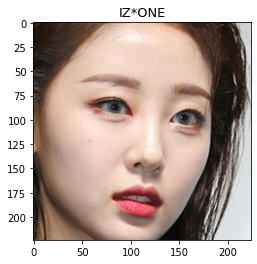

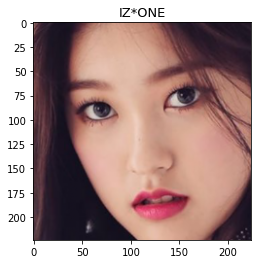

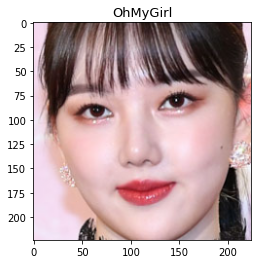

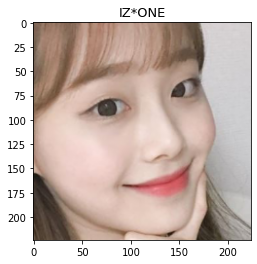

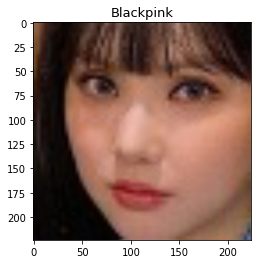

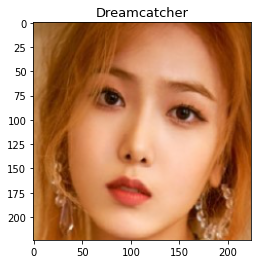

In [146]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.transform import resize
from deepface.commons import functions
import matplotlib.pyplot as plt

rec = []
for i, image in enumerate(images):
    try:
      image0 = functions.detect_face(image)   # face detection
      image1 = resize(image0[0],(224,224,3))   # resize (224,224,3)
      arr_img = img_to_array(image1)
      img = arr_img.reshape((1,)+arr_img.shape)
      
      preds = model_vgg_face.predict(img)
      
      s=preds[0]
      a = sorted(range(len(s)), key=lambda k: s[k])
      dct={0:'Dreamcatcher',1:'MAMAMOO',2:'Blackpink',3:'IZ*ONE',4:'OhMyGirl',5:'ITZY',6:'twice'}
      rec.append(dct[a[-1]])
    
      fig = plt.figure()
      plt.title(dct[a[-1]], fontdict={'fontsize':13})
      plt.imshow(image1[:,:,::1])

    except: 
      print(i+1,'번째 사진은 얼굴을 인식하지 못했습니다.', sep='')
      rec.append('')
      continue

In [148]:
rec

['IZ*ONE', 'IZ*ONE', 'OhMyGirl', 'IZ*ONE', '', 'Blackpink', 'Dreamcatcher']

In [147]:
!pip freeze > requirements.txt

# 직접 해보기

0) 저장된 모델을 불러옵니다.

1) 분석하고 싶은 사진을 업로드하세요. (여러장 가능)

2) diy 함수를 정의하세요.

3) diy()를 실행하세요.


In [ ]:
from tensorflow import keras
re_model_nocv = keras.models.load_model('/path/to/saved/model')   # saved_model.pb 저장된 경로 입력(파일명 제외하고 경로만)

In [189]:
from google.colab import files 
uploaded = files.upload()  # 여러장 업로드 후 한 번에 결과보기 가능

Saving 30러블.jpg to 30러블.jpg


In [198]:
from skimage import io
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from skimage.transform import resize
from deepface.commons import functions
import matplotlib.pyplot as plt

def diy():
  images = io.imread_collection('/content/*.jpg')
  rec = []
  for i, image in enumerate(images):
    try:
      image0 = functions.detect_face(image)   # face detection
      image1 = resize(image0[0],(224,224,3))   # resize (224,224,3)
      arr_img = img_to_array(image1)
      img = arr_img.reshape((1,)+arr_img.shape)
      
      preds = re_model_nocv.predict(img)
      
      s=preds[0]
      a = sorted(range(len(s)), key=lambda k: s[k])
      dct={0:'Dreamcatcher',1:'MAMAMOO',2:'Blackpink',3:'IZ*ONE',4:'OhMyGirl',5:'ITZY',6:'twice'}
      rec.append(dct[a[-1]])
    
      fig = plt.figure()
      plt.title(dct[a[-1]], fontdict={'fontsize':13})
      plt.imshow(image1[:,:,::1])

    except: 
      print(i+1,'번째 사진은 얼굴을 인식하지 못했습니다.', sep='')
      rec.append('')
      continue

3번째 사진은 얼굴을 인식하지 못했습니다.


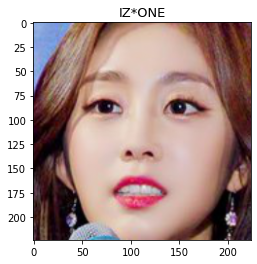

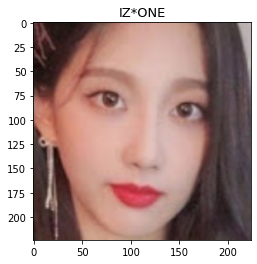

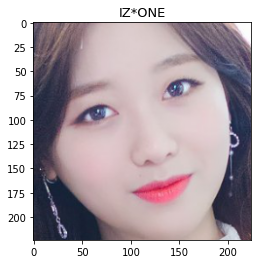

In [200]:
diy()